In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets #CIFAR10, CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import json
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!mkdir '/kaggle/working/weights'
!mkdir '/kaggle/working/history_logs'

In [4]:
def data_loader(data_dir, batch_size, random_seed = 42, shuffle = True, valid_size=0.1, test = False):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.2023, 0.1994, 0.2010)
        )
    ])

    if test:
        dataset = datasets.CIFAR100(
            root = data_dir,
            train = False,
            download = True,
            transform = transform
        )

        data_loader = DataLoader(
            dataset, batch_size = batch_size, shuffle = shuffle
        )

        return data_loader

    train_dataset = datasets.CIFAR100(
        root = data_dir,
        train = True,
        download = True,
        transform = transform
    )

    '''valid_dataset = datasets.CIFAR10(
        root = data_dir,
        train = True,
        download = True,
        transform = transform
    )'''

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size*num_train))

    if shuffle:
      np.random.seed(random_seed)
      np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(
       train_dataset, batch_size=batch_size, sampler=train_sampler
    )

    valid_loader = DataLoader(
       train_dataset, batch_size=batch_size, sampler=valid_sampler
    )

    return (train_loader, valid_loader)


train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

100%|██████████| 169001437/169001437 [00:02<00:00, 76031677.27it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class VGG16(nn.Module):
    def __init__ (self, num_classes = 10):
        super(VGG16, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [6]:
import torch.nn as nn

class VGG(nn.Module):
    def __init__(self, features, num_classes, init_weight = True):
        super(VGG, self).__init__()

        self.features_layer = features
        self.dense_layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),

            nn.Linear(4096, num_classes)
        )

        if init_weight:
            self.initialize_weight()
        
    def forward(self, x):
        out = self.features_layer(x)
        out = out.reshape(out.size(0), -1)
        out = self.dense_layer(out)
        return out
    
    def initialize_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            if isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0, std=0.01)
                nn.init.constant_(module.bias, 0)

def make_layers(cfg, batch_norm = True):
    layers = []
    in_channels = 3

    for v in cfg:
        if v=='M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            layers += [nn.Conv2d(in_channels, v, kernel_size=3, stride=1, padding=1)]
            if batch_norm:
                layers += [nn.BatchNorm2d(v)]
            layers+= [nn.ReLU()]
            in_channels = v

    return nn.Sequential(*layers)

In [7]:
def train(num_epochs, train_loader, valid_loader, classifier, criterion, optimizer, device):
    best_val_loss = float('inf')

    history_logs = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        classifier.train()
        correct_train = 0
        total_train = 0
        total_train_loss = 0.0  
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)

            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            total_train_loss += loss.item()  

            optimizer.zero_grad()  
            loss.backward()
            optimizer.step()

        average_train_loss = total_train_loss / len(train_loader)
        train_accuracy = (correct_train / total_train) * 100

        classifier.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            total_val_loss = 0.0

            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = classifier(images)
                val_loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                total_val_loss += val_loss.item()

                del images, labels, outputs

            accuracy = (correct / total) * 100
            average_val_loss = total_val_loss / len(valid_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {average_val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

        history_logs['train_loss'].append(average_train_loss)
        history_logs['train_accuracy'].append(train_accuracy)
        history_logs['val_loss'].append(average_val_loss)
        history_logs['val_accuracy'].append(accuracy)

        if average_val_loss < best_val_loss:
            torch.save(classifier.state_dict(), 'weights/best.pt')
            best_val_loss = average_val_loss

    torch.save(classifier.state_dict(), 'weights/last.pt')

    with open('/kaggle/working/history_logs/training_logs.json', 'w') as f:
        json.dump(history_logs, f, indent = 4)

In [8]:
def evaluate(test_loader, classifier, criterion, device):
    classifier.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0.0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = classifier(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

        accuracy = (correct / total) * 100
        average_loss = total_loss / len(test_loader)

        print(f'Accuracy of the model on test data: {accuracy:.2f}%')
        print(f'Average loss of the model on test data: {average_loss:.4f}')

In [9]:
num_classes = 100
num_epochs = 40
batch_size = 64
learning_rate = 0.001

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg16_classifier = VGG(make_layers(vgg16_config), num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16_classifier.parameters(), lr=learning_rate)

In [10]:
train(num_epochs, train_loader, valid_loader, vgg16_classifier, criterion, optimizer, device)

Epoch [1/40], Train Loss: 4.6069, Train Accuracy: 2.04%, Val Loss: 4.3235, Val Accuracy: 6.80%
Epoch [2/40], Train Loss: 4.3623, Train Accuracy: 4.41%, Val Loss: 4.1079, Val Accuracy: 8.10%
Epoch [3/40], Train Loss: 4.1550, Train Accuracy: 6.68%, Val Loss: 3.9302, Val Accuracy: 10.06%
Epoch [4/40], Train Loss: 4.0152, Train Accuracy: 8.52%, Val Loss: 3.8019, Val Accuracy: 12.68%
Epoch [5/40], Train Loss: 3.8824, Train Accuracy: 10.24%, Val Loss: 3.6734, Val Accuracy: 15.36%
Epoch [6/40], Train Loss: 3.7677, Train Accuracy: 12.32%, Val Loss: 3.5437, Val Accuracy: 16.64%
Epoch [7/40], Train Loss: 3.6594, Train Accuracy: 13.97%, Val Loss: 3.4395, Val Accuracy: 18.62%
Epoch [8/40], Train Loss: 3.5619, Train Accuracy: 15.70%, Val Loss: 3.3774, Val Accuracy: 18.82%
Epoch [9/40], Train Loss: 3.4863, Train Accuracy: 17.01%, Val Loss: 3.2908, Val Accuracy: 20.28%
Epoch [10/40], Train Loss: 3.4076, Train Accuracy: 18.39%, Val Loss: 3.2385, Val Accuracy: 21.20%
Epoch [11/40], Train Loss: 3.3398, 

In [11]:
evaluate(test_loader, vgg16_classifier, criterion, device)

Accuracy of the model on test data: 37.55%
Average loss of the model on test data: 2.4533


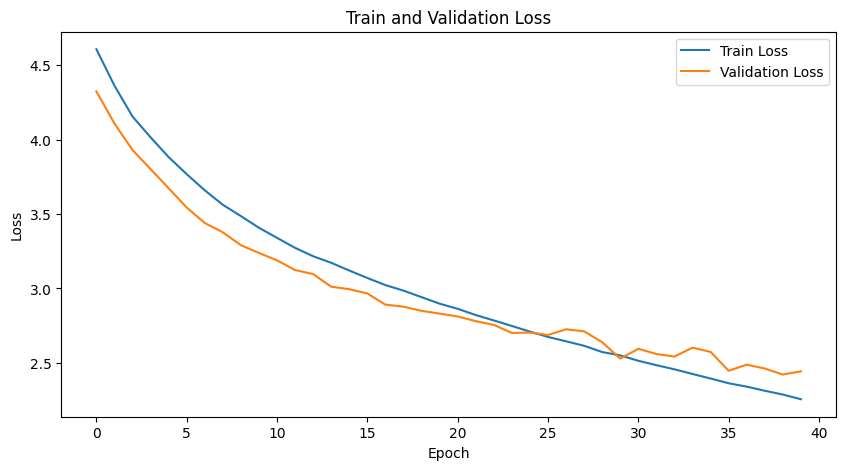

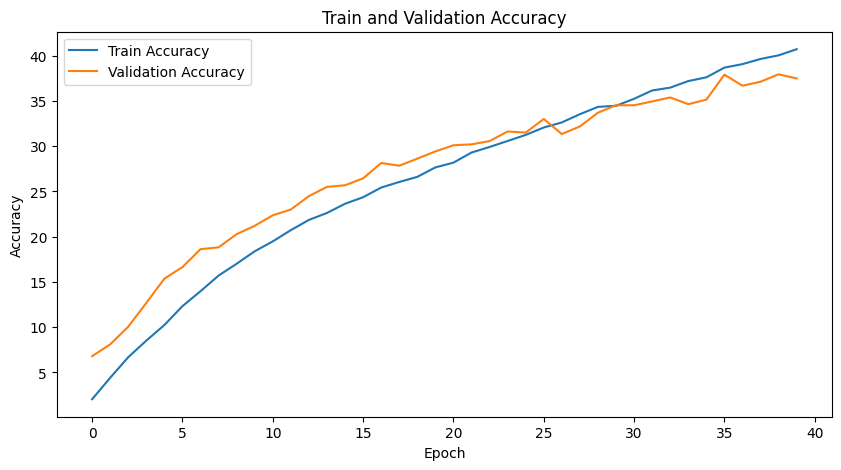

In [12]:
with open('/kaggle/working/history_logs/training_logs.json', 'r') as f:
    logs = json.load(f)

plt.figure(figsize=(10, 5))
plt.plot(logs['train_loss'], label='Train Loss')
plt.plot(logs['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(logs['train_accuracy'], label='Train Accuracy')
plt.plot(logs['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()